##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
###Load data from google driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pathlib
data_dir = "/content/drive/MyDrive/dataset/Training"
data_dir = pathlib.Path(data_dir)

Mounted at /content/drive


In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
print(data_dir)

11500
/content/drive/MyDrive/dataset/Training


## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 10
img_height = 250
img_width = 250

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11500 files belonging to 2 classes.
Using 9200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11513 files belonging to 2 classes.
Using 2302 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['clean', 'defaced']


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Overfitting

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=2, strides=2),
  layers.Dropout(0.1),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=2, strides=2),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, strides=2),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=2, strides=2),

  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation='softmax')
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 250, 250, 16)      448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 125, 125, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 125, 125, 32)     

In [ ]:
epochs=60
history = model.fit(
  train_ds.repeat(),
  steps_per_epoch=int(len(train_ds)/batch_size),
  validation_data=val_ds.repeat(),
  epochs=epochs,
  validation_steps=int(len(val_ds)/batch_size)
)

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


92/92 [==============================] - 4s 35ms/step - loss: 3.1607 - accuracy: 0.8109 - val_loss: 25.1391 - val_accuracy: 0.4957
Epoch 2/60
92/92 [==============================] - 3s 33ms/step - loss: 0.7289 - accuracy: 0.8565 - val_loss: 2.9798 - val_accuracy: 0.7304
Epoch 3/60
92/92 [==============================] - 3s 33ms/step - loss: 0.3316 - accuracy: 0.8728 - val_loss: 0.7237 - val_accuracy: 0.8174
Epoch 4/60
92/92 [==============================] - 3s 34ms/step - loss: 0.2733 - accuracy: 0.9000 - val_loss: 0.3469 - val_accuracy: 0.8696
Epoch 5/60
92/92 [==============================] - 3s 33ms/step - loss: 0.2380 - accuracy: 0.9109 - val_loss: 0.3327 - val_accuracy: 0.8783
Epoch 6/60
92/92 [==============================] - 3s 34ms/step - loss: 0.2073 - accuracy: 0.9152 - val_loss: 0.2167 - val_accuracy: 0.9348
Epoch 7/60
92/92 [==============================] - 3s 34ms/step - loss: 0.1820 - accuracy: 0.9413 - val_loss: 0.1736 - val_accuracy: 0.9130
Epoch 8/60
92/92 [=====

## Visualize training results

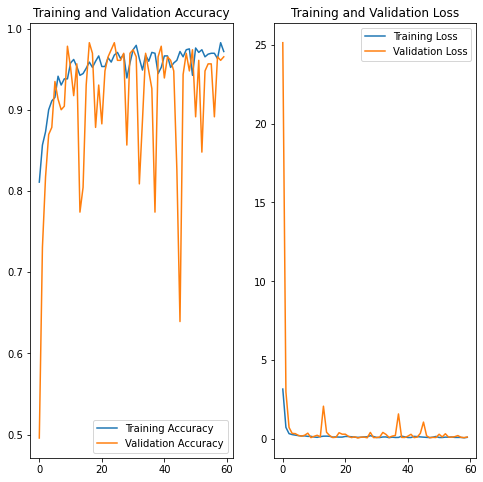

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Sau khi đào tạo mô hình xong ta sẽ lưu lại mô hình với định dạng h5. Từ mô hình này ta có thể phát triển các ứng dụng khác mà không phải đào tạo lại.
After training, we save the model with h5 format. From these model, we can development other application without retraining.

In [ ]:
model.save("/content/drive/MyDrive/dataset/final_model.h5")

## **Model evaluation**


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/dataset/final_model.h5")

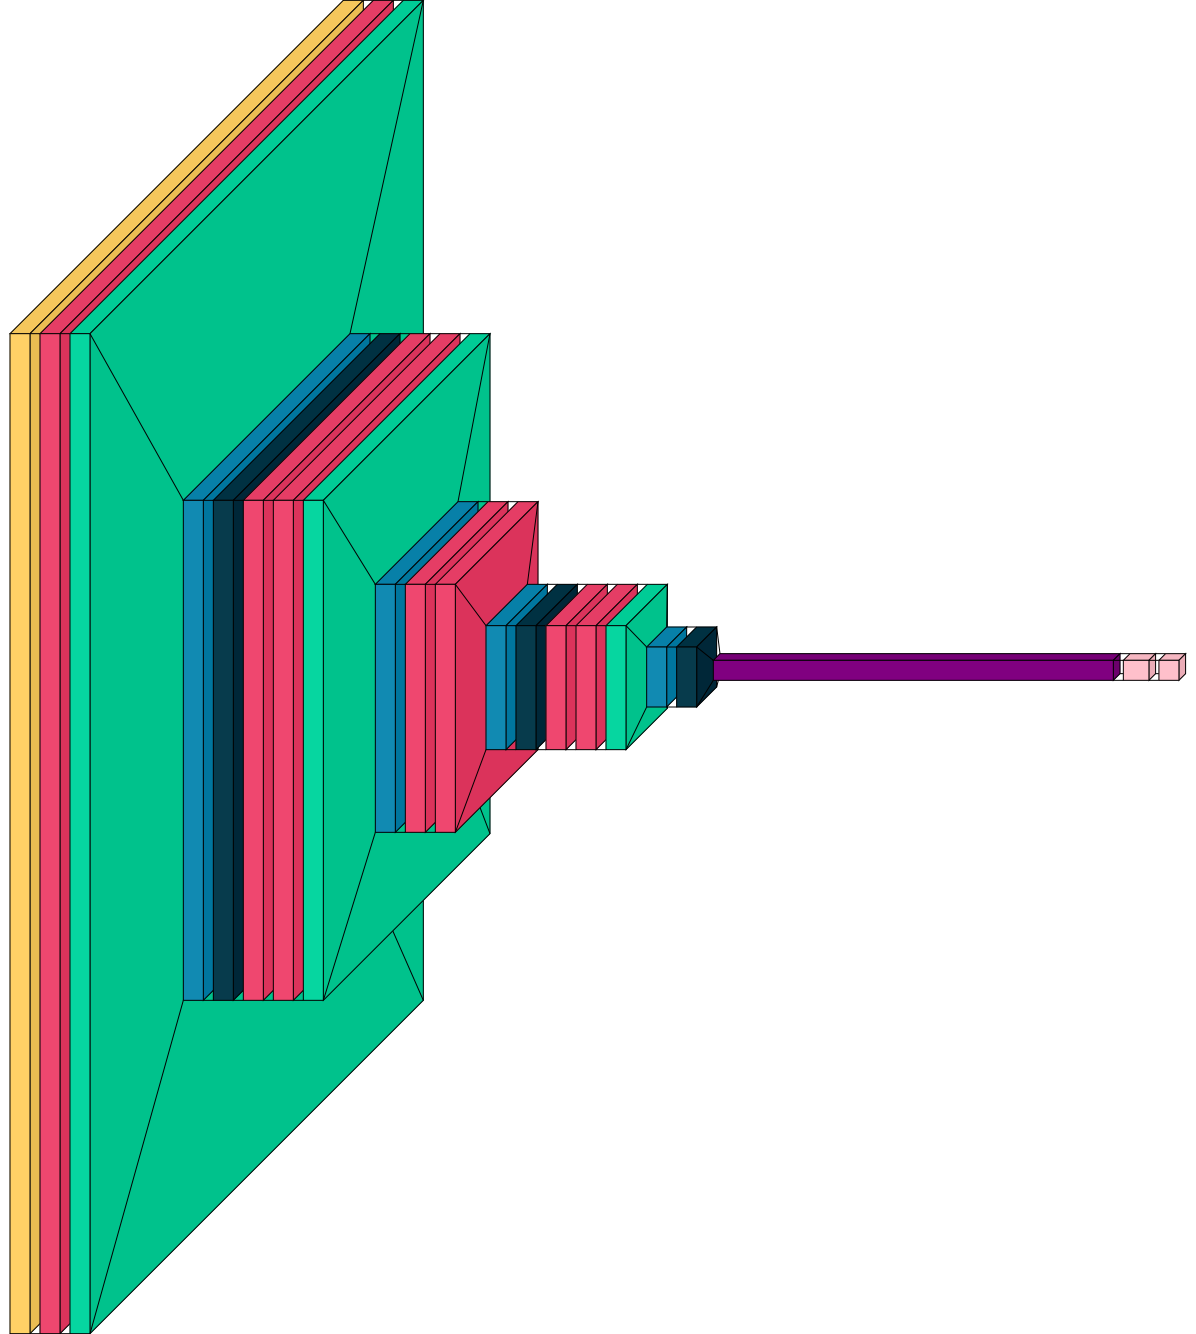

In [ ]:
!pip install visualkeras

import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Dense]['fill'] = 'pink'
color_map[Flatten]['fill'] = 'purple'

visualkeras.layered_view(model, color_map=color_map)

### Function predict images:

In [ ]:
def img_pred(img_path):
  img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) 
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return format(class_names[np.argmax(score)])

In [ ]:
test_data_dir = "/content/drive/MyDrive/dataset/Test"
test_data_dir = pathlib.Path(test_data_dir)
defaced = list(test_data_dir.glob('defaced/*'))
clean = list(test_data_dir.glob('clean/*'))
evaluate=[]
for i in range (0,len(defaced)):
  if img_pred(defaced[i]) == 'defaced':
    label = 1
  else:
    label = 0
  defaced_dic = {'class_true':'defaced','class_pred':img_pred(defaced[i]), 'label':label}
  evaluate.append(defaced_dic)

for i in range (0,len(clean)):
  if img_pred(clean[i]) == 'clean':
    label = 1
  else:
    label = 0
  clean_dic = {'class_true':'clean','class_pred':img_pred(clean[i]), 'label':label}
  evaluate.append(clean_dic)

In [ ]:
TN, TP, FP, FN = 0,0,0,0
for i in range (0, len(evaluate)):
  if evaluate[i]["class_true"] == "defaced" and evaluate[i]["label"] == 1:
    TP = TP + 1
  if evaluate[i]["class_true"] == "defaced" and evaluate[i]["label"] == 0:
    FN = FN + 1
  if evaluate[i]["class_true"] == "clean" and evaluate[i]["label"] == 1:
    TN = TN + 1
  if evaluate[i]["class_true"] == "clean" and evaluate[i]["label"] == 0:
    FP = FP + 1
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)

TP:  940
FP:  60
TN:  1547
FN:  18


Tỉ lệ cảnh báo giả
FPR = FP/(FP + TN) 

In [ ]:
FPR = FP*100/(FP + TN)
print("FPR: {:.2f}".format(FPR))

FPR: 3.73


Tỉ lệ phát hiện: TPR = TP/(TP + FN)

In [ ]:
TPR = TP*100/(TP + FN)
print("TPR: {:.2f}".format(TPR))

TPR: 98.12


Tỉ lệ cảnh báo đúng

In [ ]:
PPV = TP*100/(TP + FP)
print("PPV: {:.2f}".format(PPV))

PPV: 94.00


Tỉ lệ bỏ sót FNR = FN/(FN + TP) × 100% = 100 − TPR

In [ ]:
FNR = FN*100/(FN + TP)
print("FNR: {:.2f}".format(FNR))

FNR: 1.88


Độ chính xác tổng thể ACC = (TP + TN)/(TP + FP + TN + FN) × 100%

In [ ]:
ACC = (TP + TN)*100/(TP + FP + TN + FN)
print("ACC: {:.2f}".format(ACC))

ACC: 96.96


In [ ]:
F1 = 2*TP*100/(2*TP + FP + FN)
print("F1 Score: {:.2f}".format(F1))

F1 Score: 96.02
